**Problem 1**

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import cmath

In [2]:
def linear(A, b):
    """Computes Ax = b by solving Rx = Q^Tb
    """
    
    m, n = A.shape
    r = np.linalg.matrix_rank(A)
    if r < n:
        print("Invalid: The matrix A does not have full column rank.")
    if not len(b) == m:
        print("Invalid: The dimensions of A and b do not match")
    
    Q, R = linalg.qr(A, mode='economic')
    x = linalg.solve_triangular(R, np.dot(Q.T, b))
    
    return x

In [3]:
# Test

A = np.random.random((6, 4))
b = np.random.random(6)
x = linear(A, b)
print("Solution: "), print(x)
#print(x)
normal_left = np.dot(np.dot(A.T, A), x)
normal_right = np.dot(A.T, b)
print("Solution to normal equations: ", 
      np.allclose(normal_left, normal_right))

Solution: 
[-0.43035753  0.6977826   0.2130062   0.13441477]
Solution to normal equations:  True


**Problem 2**

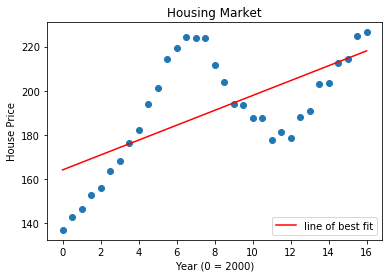

In [4]:
housing = np.load('housing.npy')
n = len(housing)
A = np.column_stack((np.ones(n), housing[:, 0]))
b = housing[:, 1]

x = linear(A, b)

A_new = housing[:, 0]
plt.scatter(A_new, b)
plt.plot(A_new, x[0] + x[1] * A_new, 'r', label = "line of best fit")
plt.xlabel('Year (0 = 2000)')
plt.ylabel('House Price')
plt.title('Housing Market')
plt.legend(loc = 'lower right') # Upper Left or lower right
plt.show()

**Problem 3**

In [5]:
x = linalg.lstsq(A, b)[0] # Given in problem 3

def polynom_fit(A, b, d):
    """Calculates polynomials of varying degrees that best fit the data
    """
    
    p3 = np.vander(A, d + 1) # Vandermonde matrix (see notes)
    x = linalg.lstsq(p3, b)[0]
    
    return x, p3

In [6]:
x, p3 = polynom_fit(A_new, b, 3)

x_new = np.polyfit(A_new, b, 3)
x_new

array([  0.15333253,  -4.13096835,  33.78211221, 116.92029369])

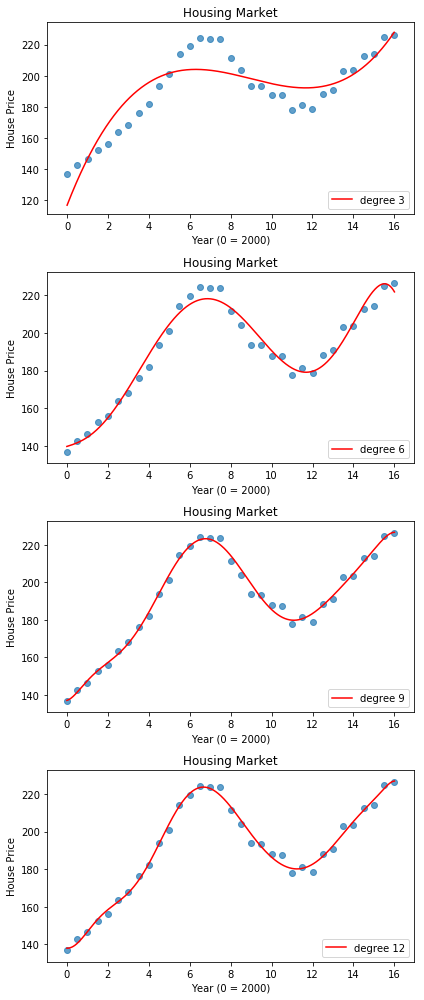

In [7]:
fig, axes = plt.subplots(4, 1, figsize = (6, 14))
grid = np.linspace(0, 16, 1_000)

for i, d in enumerate([3, 6, 9, 12]): # degree 3, 6, 9, and 12
    x, vander = polynom_fit(A_new, b, d)
    bhat = np.vander(grid, d + 1) @ x
    
    axes[i].plot(grid, bhat, 'r', label = 'degree {}'.format(d))
    axes[i].scatter(A_new, b, alpha = .7)
    axes[i].legend(loc = 'lower right')
    axes[i].set_xlabel('Year (0 = 2000)')
    axes[i].set_ylabel('House Price')
    axes[i].set_title('Housing Market')
    plt.tight_layout()

**Problem 4**

In [8]:
ellipse = np.load('ellipse.npy')

x = ellipse[:, 0]
y = ellipse[:, 1]
A = np.column_stack((x ** 2, x, x * y, y, y ** 2))
n = len(ellipse)
beta = linalg.lstsq(A, np.ones(n))[0]

In [9]:
def elps_plot(a, b, c, d, e):
    """Calcultaes te parameters for the ellipse thet best fits the data
    in ellipse.npy
    """
    
    θ = np.linspace(0, 2 * np.pi, 200)
    cos_t, sin_t = np.cos(θ), np.sin(θ)
    A = a * (cos_t ** 2) + c * cos_t * sin_t + e * (sin_t ** 2)
    B = b * cos_t + d * sin_t
    r = (-B + np.sqrt(B ** 2 + 4 * A)) / (2 * A)
    plt.plot(r * cos_t, r * sin_t, lw=2)
    plt.gca().set_aspect("equal", "datalim")

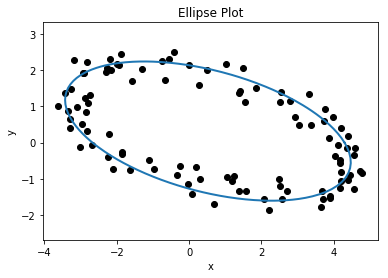

In [10]:
plt.scatter(x, y, color = 'black')
elps_plot(beta[0], beta[1], beta[2], beta[3], beta[4])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ellipse Plot')
plt.show()

**Problem 5**

In [11]:
def power_meth(A, N, tol):
    """Implements the power method algorithm (see notes)
    """
    m, n = A.shape
    if not n == m:
        print("Invalid: A is not a square matrix.")
    
    x1 = np.random.random(n)
    x1 = x1 / linalg.norm(x1)
    distance = tol + 1
    i = 1
    while (i < N) and (distance > tol):
        x2 = A @ x1
        x2 = x2 / linalg.norm(x2)
        distance = linalg.norm(x2 - x1)
        x1 = x2
        i += 1
    
    return (x2.T @ A) @ x2, x2

In [12]:
# Test

A = np.random.random((6, 6))
eig_vals1, vecs1 = power_meth(A, 100_000, 1e-8)
eig_vals2, vecs2 = linalg.eig(A)

print(eig_vals1)
print(eig_vals1.max())
print(np.allclose(A @ vecs1, eig_vals1 * vecs1))

2.7311844184361593
2.7311844184361593
True


**Problem 6**

In [13]:
def precond_hessen(A, N, tol):
    """Implements the QR algorithm with Hessenberg preconditioning
    """
    
    m, n = A.shape
    if not n == m:
        print("Invalid: A is not a square matrix.")
    
    S = linalg.hessenberg(A)
    
    for k in range(N):
        Q, R = linalg.qr(S)
        S = R @ Q
    eigs = []
    i = 0
    
    while i < n:
        if (i < n - 1 and abs(S[i + 1, i]) < tol) or (i == n - 1):
            eigs.append(S[i, i])
        else:
            eigs.append(S[i, i] + 
                        S[i + 1, i + 1] + 
                        cmath.sqrt((S[i, i] + S[i + 1, i + 1]) ** 2 - 
                                   4 * (S[i, i + 1] * S[i + 1, 1]))) / 2
            eigs.append(S[i, i] + S[i + 1, i + 1] - 
                        cmath.sqrt((S[i, i] + S[i + 1, i + 1]) ** 2 - 
                                   4 * (S[i, i + 1] * S[i + 1, 1]))) / 2
            i += 1
        i += 1
    
    return eigs

In [14]:
# Test

A = np.random.random((4, 4))
AAT = A @ A.T

print(precond_hessen(AAT, 100_000, 1e-8), "\n")
print(linalg.eig(AAT)[0])

[6.274131978777321, 0.688059284313621, 0.2235628938071209, 0.02150260119682556] 

[6.27413198+0.j 0.68805928+0.j 0.0215026 +0.j 0.22356289+0.j]
